In [16]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader, ConcatDataset
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import piq
import random
import time

In [17]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


# Dataset

In [18]:
class DepthDataSet(data.Dataset):
    def __init__(self,images_path,depth_path,transform=None):
        self.image_path = images_path
        self.depth_path = depth_path
        self.transform = transform

        self.image_files = ([
            f for f in os.listdir(self.image_path)
            if os.path.isfile(os.path.join(self.image_path,f))
            ])
        self.depth_files = ([
            f for f in os.listdir(self.depth_path)
            if os.path.isfile(os.path.join(self.depth_path,f))
            ])

    def __len__(self):
        return len(self.depth_files)
    
    def __getitem__(self, index):
        image_file = self.image_files[index]
        depth_file = self.depth_files[index]
        
        img_path = os.path.join(self.image_path, image_file)
        dpth_path = os.path.join(self.depth_path, depth_file)


        image = Image.open(img_path)
        image = self.transform(image)


        mat_file = loadmat(dpth_path)
        depth = mat_file.get("Position3DGrid")
        depth = depth[:,:,3]
        depth = np.log1p(depth)

        depth = cv.resize(depth, (1704,2272), interpolation=cv.INTER_CUBIC)
        depth = cv.normalize(depth, None, 0, 255, cv.NORM_MINMAX)
        depth = depth.astype(np.uint8)

        depth = np.expand_dims(depth,axis=2)

        depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
        return image, depth

        

In [19]:
train_dataset = DepthDataSet(images_path='./data/train/imgs',depth_path='./data/train/depths',transform=transforms.ToTensor())
val_dataset = DepthDataSet(images_path='./data/test/imgs',depth_path='./data/test/depths',transform=transforms.ToTensor())

## Testing dataset

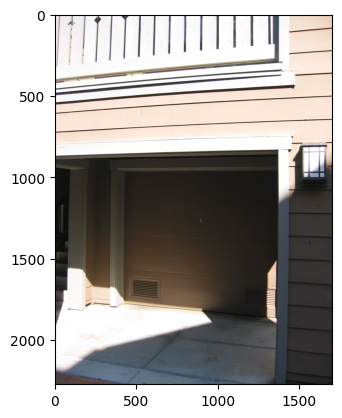

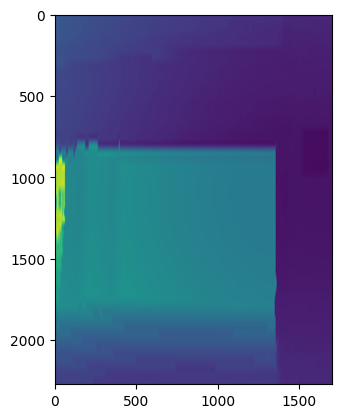

In [10]:
index=47
image,depth = train_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth = depth.cpu().permute(1,2,0).numpy()
plt.imshow(depth)
plt.show()

# Image manipulation

In [20]:
def equalizeDepth(depth):
    depth = depth.cpu().permute(1,2,0).numpy()
    depth = ((depth-depth.min()) / (depth.max()-depth.min())) * 255
    depth = depth.astype(np.uint8)
    depth = cv.equalizeHist(depth)

    depth = np.expand_dims(depth, axis=0)

    depth = torch.tensor(depth)
    depth = depth.float()/255.0

    return depth

In [25]:
def equalizeImage(image):
    image = image.cpu().permute(1,2,0).numpy()

    gamma = .6
    image = np.power(image,gamma)

    # image = image*255
    image = ((image-image.min()) / (image.max()-image.min())) * 255

    # image = (image-np.mean(image)) - np.std(image)

    image = image.astype(np.uint8)

    
    b,g,r = cv.split(image)
    b_eq = cv.equalizeHist(b)
    g_eq = cv.equalizeHist(g)
    r_eq = cv.equalizeHist(r)

    image = cv.merge([b_eq,g_eq,r_eq])


    image = torch.tensor(image).permute(2,0,1)
    image = image.float()/255.0
    return image

## Test manipulation

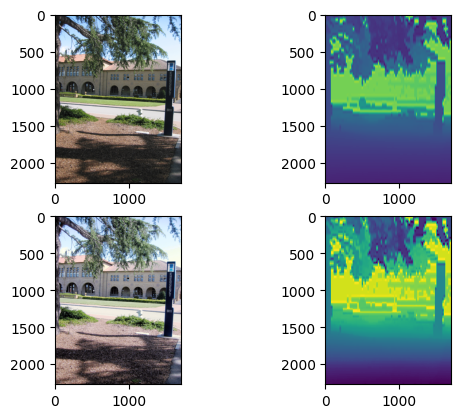

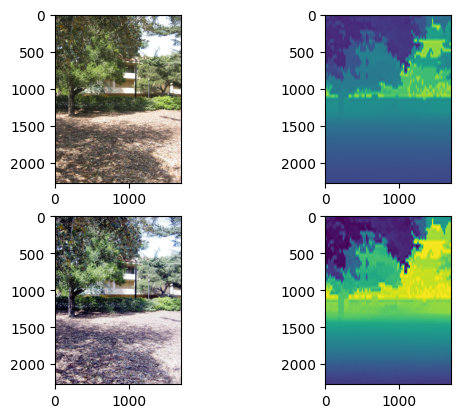

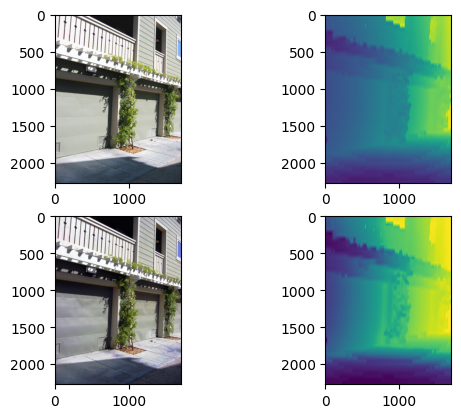

In [26]:

random.seed(time.time())
list = [i for i in range(400)]
indices = random.sample(list,3)
for index in indices:
    image,depth_map = train_dataset[index]
    equalized_image = equalizeImage(image)
    equalized_depth_map = equalizeDepth(depth_map)
    

    fig,axs = plt.subplots(2,2)
    axs[0,0].imshow(image.cpu().permute(1,2,0).numpy())
    axs[1,0].imshow(equalized_image.cpu().permute(1,2,0).numpy())
    

    axs[0,1].imshow(depth_map.cpu().permute(1,2,0).numpy())
    axs[1,1].imshow(equalized_depth_map.cpu().permute(1,2,0).numpy())

    plt.show()

# Dataloader

In [27]:
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=8,shuffle=True)

# AE Model

In [283]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder,self).__init__()
        #bias for skip
        self.bias4 = nn.Parameter(torch.ones(1))
        self.bias3 = nn.Parameter(torch.ones(1))
        self.bias2 = nn.Parameter(torch.ones(1))
        self.bias1 = nn.Parameter(torch.ones(1))

        self.relu4 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu1 = nn.ReLU()

        self.dropout4 = nn.Dropout2d(.1)
        self.dropout3 = nn.Dropout2d(.1)
        self.dropout2 = nn.Dropout2d(.1)
        self.dropout1 = nn.Dropout2d(.1)
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5,stride=2,padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=24,out_channels=36,kernel_size=7,stride=2,padding=1),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=36,out_channels=48,kernel_size=5,stride=2,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.encoder_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        #decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=48,kernel_size=3,stride=1,padding=1),
            # nn.AdaptiveAvgPool2d((143, 107)),
            nn.BatchNorm2d(48),
            # nn.ReLU()
        )

        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48,out_channels=36,kernel_size=5,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((282,211)),
            nn.BatchNorm2d(36),
            # nn.ReLU()
        )

        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=36,out_channels=24,kernel_size=7,stride=2,padding=1),
            # nn.AdaptiveAvgPool2d((567,425)),
            nn.BatchNorm2d(24),
            # nn.ReLU()
        )

        self.decoder_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=24,out_channels=12,kernel_size=5,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((1136,852)),
            nn.BatchNorm2d(12),
            # nn.ReLU()
        )

        self.decoder_conv4_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=12,out_channels=6,kernel_size=3,stride=1,padding=1),
            # nn.AdaptiveAvgPool2d((1136,852)),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Dropout2d(.1)
        )

        self.decoder_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=6,out_channels=1,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((2272,1704)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )


    def forward(self,x):
        encoder_x1 = self.encoder_conv1(x) #12
        encoder_x2 = self.encoder_conv2(encoder_x1) #24
        encoder_x3 = self.encoder_conv3(encoder_x2) #36
        encoder_x4 = self.encoder_conv4(encoder_x3) #48
        encoder_x5 = self.encoder_conv5(encoder_x4) #64

        x_d = self.decoder_conv1(encoder_x5)
        x_d = x_d + (encoder_x4 * self.bias4)
        x_d = self.relu4(x_d)
        x_d = self.dropout1(x_d)
        
        x_d = self.decoder_conv2(x_d)
        x_d = x_d + (encoder_x3 * self.bias3)
        x_d = self.relu3(x_d)
        x_d = self.dropout2(x_d)

        x_d = self.decoder_conv3(x_d)
        x_d = x_d = (encoder_x2 * self.bias2)
        x_d = self.relu2(x_d)
        x_d = self.dropout3(x_d)

        x_d = self.decoder_conv4(x_d)
        x_d = x_d + (encoder_x1 * self.bias1)
        x_d = self.relu1(x_d)
        x_d = self.dropout4(x_d)

        x_d = self.decoder_conv4_5(x_d)

        x_d = self.decoder_conv5(x_d)

        return x_d


In [284]:
encoder_decoder = EncoderDecoder()
encoder_decoder.to(device)
summary(encoder_decoder,(3,2272, 1704))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 12, 1136, 852]             336
       BatchNorm2d-2        [-1, 12, 1136, 852]              24
              ReLU-3        [-1, 12, 1136, 852]               0
         Dropout2d-4        [-1, 12, 1136, 852]               0
            Conv2d-5         [-1, 24, 567, 425]           7,224
       BatchNorm2d-6         [-1, 24, 567, 425]              48
              ReLU-7         [-1, 24, 567, 425]               0
         Dropout2d-8         [-1, 24, 567, 425]               0
            Conv2d-9         [-1, 36, 282, 211]          42,372
      BatchNorm2d-10         [-1, 36, 282, 211]              72
             ReLU-11         [-1, 36, 282, 211]               0
        Dropout2d-12         [-1, 36, 282, 211]               0
           Conv2d-13         [-1, 48, 140, 105]          43,248
      BatchNorm2d-14         [-1, 48, 1

In [285]:
del encoder_decoder

# Training

In [286]:
def save_check(epoch, model, optimizer, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f'Saved model at epoch:{epoch}')

In [295]:
model = EncoderDecoder()
model.to(device)

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (dropout4): Dropout2d(p=0.1, inplace=False)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

In [296]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.5)

In [297]:
def l1_ssim_loss(input1,input2,bias=0.75):
    ssim_loss = piq.ssim(input1,input2,1.0)
    l1_loss = nn.L1Loss()(input1,input2)
    return (l1_loss * bias) + ((1-bias) * ssim_loss)

In [298]:
loss = l1_ssim_loss

In [299]:
def train(encoder_decoder,train_dataloader,val_dataloader,optimizer, criterion, scheduler, epochs=2):
    for epoch in range(epochs):
        encoder_decoder.train()
        total_loss = 0.0
        batch_num = 0
        for data,depth_data in train_dataloader:

            batch_num+=1
            
            inputs = data
            ground_truth = depth_data
            # ground_truth = (depth_data - depth_data.min()) / (depth_data.max() - depth_data.min())
            

            inputs = np.array([equalizeImage(img) for img in inputs])            
            ground_truth = np.array([equalizeDepth(depths) for depths in ground_truth])
            
            inputs = torch.from_numpy(inputs)
            ground_truth = torch.from_numpy(ground_truth)
            
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            optimizer.zero_grad()

            result = encoder_decoder(inputs)
            
            loss = criterion(result,ground_truth)

            loss.backward()

            optimizer.step()
            
            curr_loss = loss.item()
            total_loss+= curr_loss

            torch.cuda.empty_cache()
            print("Batch:{:3d}/{:3d}{:10}Loss{:10f}{:10}{:2d}/{:2d}".format(batch_num,len(train_dataloader),"",curr_loss,"",epoch,epochs))
        scheduler.step()
        filename ="./models/checkpoints"
        save_check(epoch,encoder_decoder,optimizer,criterion,f"{filename}/encoder_decoder_{epoch}.pth")

In [300]:
train(model,train_dataloader,val_dataloader,optimizer,loss,scheduler,epochs=20)

OutOfMemoryError: CUDA out of memory. Tried to allocate 356.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 468.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
file_name = "default_v3"
torch.save(model,f"./models/saved/{file_name}.pb")
torch.save(model.state_dict(),f"./models/saved/{file_name}_state.pth")

In [293]:
model2 = torch.load("./models/saved/default_v2.pb",weights_only=False)

In [ ]:
train(model2,train_dataloader,val_dataloader,optimizer,loss,scheduler,epochs=2)

In [260]:
model.eval()

EncoderDecoder(
  (relu4): ReLU()
  (relu3): ReLU()
  (relu2): ReLU()
  (relu1): ReLU()
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(24, 36, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_conv5): Sequential(
    (0): Conv2d(48, 64

In [187]:
from skimage.metrics import structural_similarity as ssim
def structuralSimilarityIndex(input1, input2):
    input1 = input1.squeeze().cpu().numpy()
    input2 = input2.squeeze().cpu().numpy()
    # print(input1.min())
    input1 = (input1 * 255).astype(np.uint8)
    input2 = (input2 * 255).astype(np.uint8)

    accuracy, diff_map = ssim(input1,input2,full=True)
    return accuracy, diff_map

    

In [192]:
def compareResults(model,dataloader, num_batches=3):
    i = 0
    for images, depths in dataloader:
        if i>=num_batches:
            break
        images = np.array([equalizeImage(img) for img in images])            
        depths = np.array([equalizeDepth(dpth) for dpth in depths])

        images = torch.from_numpy(images)
        depths = torch.from_numpy(depths)

        # print(images)
        with torch.no_grad():
            result = model(images.to(device))

            result = result.to("cpu")
            result = result.detach()
        for i in range(result.shape[0]):
            fig, axs = plt.subplots(1,4)
            axs[0].imshow(images[i].permute(1,2,0))

            axs[1].imshow(depths[i].permute(1,2,0))

            depth = np.array(result[i].permute(1,2,0)*255,dtype=np.uint8)
            
            axs[2].imshow(depth)

            
            print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
            # print(depths[i]-result[i])
            accuracy, diff_map = structuralSimilarityIndex(depths[i],result[i])
            print(f"accuracy:{accuracy}")
            axs[3].imshow(diff_map)
            
            plt.show()
        i+=1
        

mean:117.07583208316802
var:1191.4391882370624
max:241
accuracy:0.5120946242613956


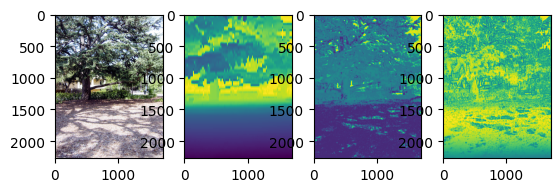

mean:115.71971629512993
var:1111.0541034732873
max:248
accuracy:0.519993971430054


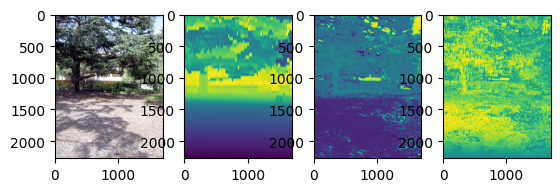

mean:122.11887858105204
var:1345.57237286503
max:245
accuracy:0.4731757256086306


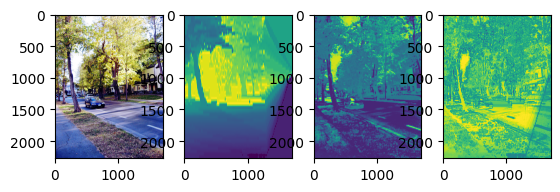

mean:131.9692449001521
var:1895.2805386589778
max:235
accuracy:0.5248445180377502


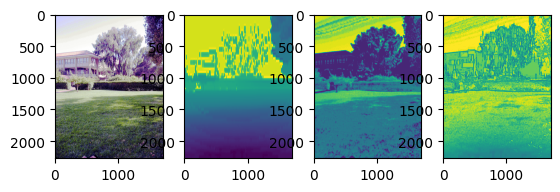

mean:141.9551211317199
var:2159.604620855443
max:243
accuracy:0.6192682533484849


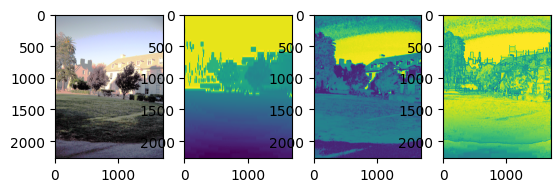

mean:125.69992442182438
var:1041.129430724798
max:241
accuracy:0.4601719839921038


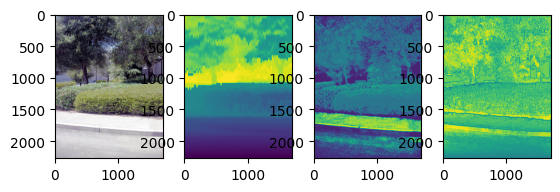

mean:124.20471198670899
var:1462.6496441580223
max:240
accuracy:0.5335810797192053


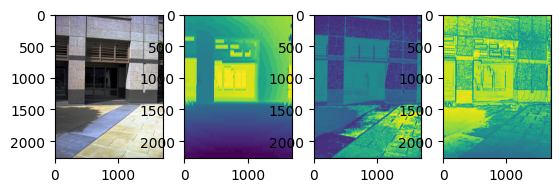

mean:146.1336232993619
var:2459.049476289517
max:252
accuracy:0.5630359120900604


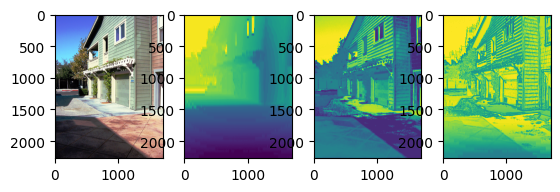

In [261]:
compareResults(model,val_dataloader,num_batches=2)

# Loading another data set*
*may not be completed

In [129]:
model = torch.load("./models/saved/default_model.pth",weights_only=False)
model.eval()
print(model)
print(hasattr(model,'encoder_conv1'))

compareResults(model,val_dataloader)

EncoderDecoder(
  (Encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(24, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(36, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv5): Sequential(
      (0): Conv2d(48, 

AttributeError: 'EncoderDecoder' object has no attribute 'encoder_conv1'

In [154]:
from datasets import load_dataset

nyu_depth_dataset = load_dataset("sayakpaul/nyu_depth_v2",trust_remote_code=True)

Loading dataset shards:   0%|          | 0/127 [00:00<?, ?it/s]

In [155]:
def colored_depthmap(depth, d_min=None, d_max=None):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * plt.cm.viridis(depth_relative)[:,:,:3]

def show_depthmap(depth_map):
   if not isinstance(depth_map, np.ndarray):
       depth_map = np.array(depth_map)
   if depth_map.ndim == 3:
       depth_map = depth_map.squeeze()

   d_min = np.min(depth_map)
   d_max = np.max(depth_map)
   depth_map = colored_depthmap(depth_map, d_min, d_max)

   plt.imshow(depth_map.astype("uint8"))
   plt.axis("off")
   plt.show()


In [156]:
class NyuDataset(data.Dataset):
    def __init__(self,dataset,tranform_image=None,transform_depth=None):
        self.dataset = dataset
        self.transform_image = tranform_image
        self.transform_depth = transform_depth

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image = self.dataset[index]['image']
        depth = self.dataset[index]['depth_map']
        
        
        d_min = np.min(depth)
        d_max = np.max(depth)

        depth_relative = (depth - d_min) / (d_max - d_min)
        depth =  255 * plt.cm.viridis(depth_relative)[:,:,:3]

        
        transform = transforms.ToTensor()
        image = transform(image)
        depth = transform(depth)
        

        if self.transform_image:
            image = self.transform_image(image)
        
        if self.transform_depth:
            depth = self.transform_depth(depth)
        
        return image, depth

In [ ]:
random_frames_indices =  np.random.choice(len(nyu_depth_dataset["train"]),400).tolist()
train_sub_dataset = nyu_depth_dataset["train"].select(random_frames_indices)

train_nyu_dataset = NyuDataset(train_sub_dataset)

train_nyu_dataloader = DataLoader(train_nyu_dataset,batch_size=8,shuffle=True)


In [106]:
image, depth = next(iter(train_nyu_dataloader))

In [ ]:
class EncoderDecoderAdaptive(nn.Module):
    def __init__(self):
        super(EncoderDecoderAdaptive,self).__init__()
        #pool
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1000,1000))
        
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=24,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=24,out_channels=36,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=36,out_channels=48,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.encoder_conv5 = nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        #decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=48,kernel_size=3,stride=2,padding=1),
            # nn.AdaptiveAvgPool2d((250, 250)),
            nn.AdaptiveAvgPool2d((500,500)),

            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48,out_channels=36,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((500,500)),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=36,out_channels=24,kernel_size=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((500,500)),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=24,out_channels=12,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((1000,1000)),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )

        self.decoder_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=12,out_channels=1,kernel_size=9,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1000,1000)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )


    def forward(self,x):

        x_resized = self.adaptive_pool(x)
        encoder_x1 = self.encoder_conv1(x_resized) #12
        encoder_x2 = self.encoder_conv2(encoder_x1) #24
        encoder_x3 = self.encoder_conv3(encoder_x2) #36
        encoder_x4 = self.encoder_conv4(encoder_x3) #48
        encoder_x5 = self.encoder_conv5(encoder_x4) #64

        x = self.decoder_conv1(encoder_x5)
        x = x + encoder_x4
        
        x = self.decoder_conv2(x)
        x = x + encoder_x3

        x = self.decoder_conv3(x)
        x = x = encoder_x2

        x = self.decoder_conv4(x)
        x = x + encoder_x1

        x = self.decoder_conv5(x)
        x = x
        return x     


In [163]:
model = EncoderDecoderAdaptive()
model.to(device)
summary(model,(3,480,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1        [-1, 3, 1000, 1000]               0
            Conv2d-2       [-1, 12, 1000, 1000]             336
       BatchNorm2d-3       [-1, 12, 1000, 1000]              24
              ReLU-4       [-1, 12, 1000, 1000]               0
            Conv2d-5       [-1, 24, 1000, 1000]           2,616
       BatchNorm2d-6       [-1, 24, 1000, 1000]              48
              ReLU-7       [-1, 24, 1000, 1000]               0
            Conv2d-8         [-1, 36, 500, 500]           7,812
       BatchNorm2d-9         [-1, 36, 500, 500]              72
             ReLU-10         [-1, 36, 500, 500]               0
           Conv2d-11         [-1, 48, 500, 500]          15,600
      BatchNorm2d-12         [-1, 48, 500, 500]              96
             ReLU-13         [-1, 48, 500, 500]               0
           Conv2d-14         [-1, 64, 2